# Define utility functions and load config variables

In [24]:
import requests
import yaml

# Define utility functions
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

def download_file(url, filename, download_dir='.'):
    file_path = f'{download_dir}/{filename}'
    print(f'Downloading {url} as {file_path}...')
    res = requests.get(url, stream=True)
    if res.status_code == 200:
        with open(f'{file_path}', 'wb') as f:
            for chunk in res.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f'{file_path} downloaded')
    else:
        eprint(f'Failed to download {filename}')

# Load configuration
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# Create directories for input and output data

In [29]:
import os

input_dir = os.path.dirname(config['paths']['shapefile_input'])
output_dir = os.path.dirname(config['paths']['filtered_shapefile_output'])

# Create the input and output directories if they don't exist
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Download FEMA NFHL data for the study site

In [30]:
nfhl_url = config['data']['nfhl_url']
nfhl_filename = config['data']['nfhl_filename']

# Download NFHL data
download_file(nfhl_url, nfhl_filename, input_dir)

input/24025C_20211015.zip downloaded


# Download other data for training

In [31]:
raster_url = config['data']['raster_url']
raster_filename = config['data']['raster_filename']

# Download raster data
download_file(raster_url, raster_filename, input_dir)

input/DEM_Parameters.tif downloaded


# Extract FEMA's floodplain shapefile

In [33]:
import zipfile

with zipfile.ZipFile(f'{input_dir}/{nfhl_filename}', 'r') as zipf:
    for filename in zipf.namelist():
        if filename.startswith('S_FLD_HAZ_AR.'):
            print(f'Extracting {input_dir}/{filename}')
            zipf.extract(filename, input_dir)

Extracting input/S_FLD_HAZ_AR.dbf
Extracting input/S_FLD_HAZ_AR.prj
Extracting input/S_FLD_HAZ_AR.shp
Extracting input/S_FLD_HAZ_AR.shx


# Extract the 100-year floodplain

In [35]:
import geopandas as gpd
from geotile import GeoTile
import numpy as np

shapefile_input = config['paths']['shapefile_input']
filtered_shapefile_output = config['paths']['filtered_shapefile_output']
raster_input = config['paths']['raster_input']
rasterized_output = config['paths']['rasterized_output']
tiles_output = config['paths']['tiles_output']
labels_output = config['paths']['labels_output']

# Load the shapefile
fld = gpd.read_file(shapefile_input)
print(f"Initial shapefile records: {len(fld)}")

# Filter the shapefile to include only zones 'A' and 'AE'
fld_filtered = fld[fld['FLD_ZONE'].isin(['A', 'AE'])]
print(f"Filtered shapefile records: {len(fld_filtered)}")

# Export the filtered shapefile
fld_filtered.to_file(filtered_shapefile_output)
print(f"Filtered shapefile exported to: {filtered_shapefile_output}")

# Load the raster data using GeoTile
gt_train = GeoTile(raster_input)
gt_train.meta

# Generate tiles and save
gt_train.generate_tiles(tiles_output, prefix='train_')

# Rasterize the shapefile and save as .tif
gt_train.rasterization(filtered_shapefile_output, rasterized_output)

# Load the rasterized shapefile and generate tiles
gt_train_y = GeoTile(rasterized_output)
gt_train_y.generate_tiles(labels_output, prefix='train_')

# Preprocess tiles (convert NaN to zero and normalize)
gt_train.generate_tiles(save_tiles=False)
gt_train_y.generate_tiles(save_tiles=False)
gt_train.convert_nan_to_zero()
gt_train.normalize_tiles()

# Save tiles as numpy arrays
x_train_path = config['paths']['x_train']
y_train_path = config['paths']['y_train']
gt_train.save_numpy(x_train_path)
gt_train_y.save_numpy(y_train_path)

# Load numpy arrays and check data properties
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
print(X_train.max(), X_train.min(), X_train.dtype, X_train.shape)
print(y_train.shape)

Initial shapefile records: 3210
Filtered shapefile records: 2056
Filtered shapefile exported to: output/S_FLD_HAZ_AR_A.shp
CRS of raster doesn't match with vector. Reprojecting the vector (EPSG:4269) to the raster coordinate system (EPSG:4326)
1.0 0.0 float32 (255, 256, 256, 14)
(255, 256, 256, 1)


# Create and train a deep learning model

(204, 256, 256, 14) (204, 256, 256, 1) (51, 256, 256, 14) (51, 256, 256, 1)
1.0 0.0 float32
(816, 256, 256, 14) (816, 256, 256, 1)


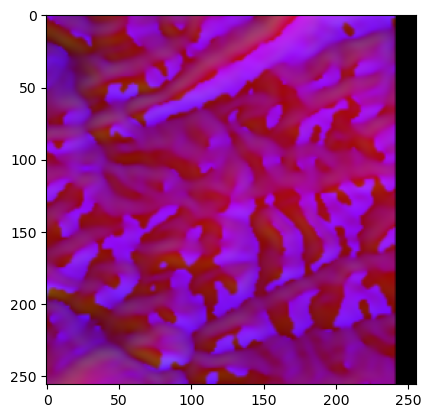

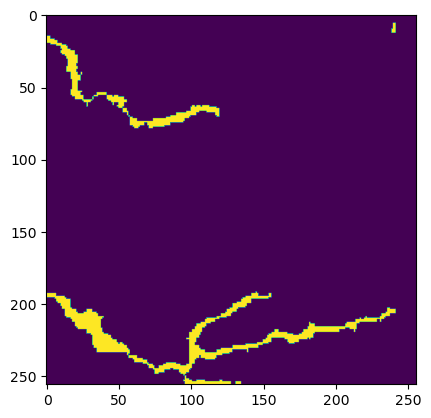

Class weights tensor: tf.Tensor([ 0.52297765 11.380141  ], shape=(2,), dtype=float32)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │      4,064 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 256, 256,  │          0 │ conv2d_33[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │      9,248 │ dropout_24[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 128, 128,  │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │      9,248 │ max_pooling2d_9[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128, 128,  │          0 │ conv2d_35[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_25[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_36[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64, 64,    │          0 │ conv2d_37[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_26[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     36,928 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 32, 32,    │          0 │ conv2d_39[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_27[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_24 │ (None, 32, 32,    │     36,928 │ conv2d_40[0][0] 

 Total params: 412,449 (1.57 MB)

 Trainable params: 412,449 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - loss: 0.6063
Epoch 1: val_loss improved from inf to 0.56615, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 533ms/step - loss: 0.6053 - val_loss: 0.5662
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.5522
Epoch 2: val_loss improved from 0.56615 to 0.49959, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.5500 - val_loss: 0.4996
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.4598
Epoch 3: val_loss improved from 0.49959 to 0.45195, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.4574 - val_loss: 0.4520
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.3583
Epoch 4: val_loss improved from 0.45195 to 0.35291, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.3578 - val_loss: 0.3529
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.4

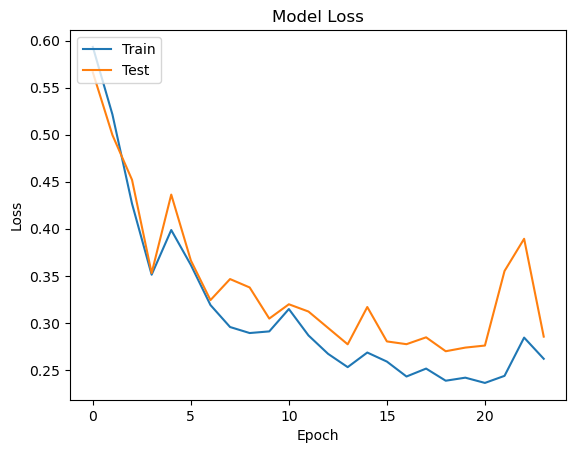

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
(51, 256, 256, 1)


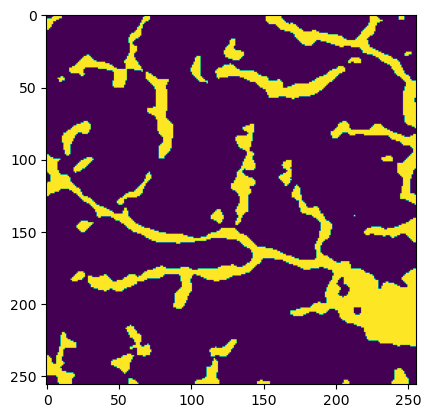

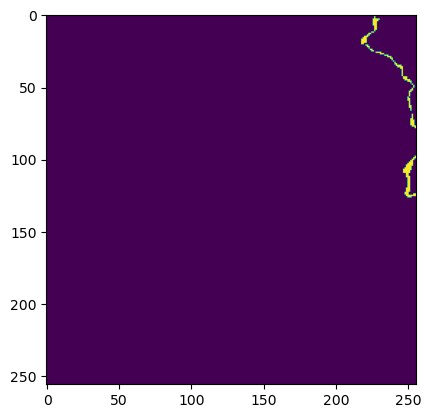

(0.1418394459062612, 0.8979465157929013, 0.2449816422706672, 0.1395892192191242)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(72, 256, 256, 1)


'output/file.shp'

In [43]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
from keras.models import Model, load_model
from sklearn.utils import class_weight
from geotile import mosaic, vectorize

x_train_path = config['paths']['x_train']
y_train_path = config['paths']['y_train']
x_test_path = config['paths']['x_test']
y_test_path = config['paths']['y_test']
best_model_path = config['paths']['best_model']
prediction_tiles_path = config['paths']['prediction_tiles']
merged_raster_output = config['paths']['merged_raster_output']
vectorized_output = config['paths']['vectorized_output']
raster_input = config['paths']['raster_input']

# Load initial data
train_xx = np.load(x_train_path)
train_yy = np.load(y_train_path)

# Split data into training and test sets
train_xx_initial, test_xx, train_yy_initial, test_yy = train_test_split(train_xx, train_yy, test_size=0.2, random_state=42)
np.save(x_test_path, test_xx)
np.save(y_test_path, test_yy)
print(train_xx_initial.shape, train_yy_initial.shape, test_xx.shape, test_yy.shape)

# Data augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5), 
    iaa.Flipud(0.5), 
    iaa.Affine(rotate=(-45, 45)), 
    iaa.Affine(scale=(0.5, 1.5)), 
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
])

augmented_images, augmented_masks = [], []
num_augmentations = 3

for i in range(train_xx_initial.shape[0]):
    image, mask = train_xx_initial[i], train_yy_initial[i]
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    for _ in range(num_augmentations):
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Append augmented data to original data
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)
del augmented_images, augmented_masks

print(train_xx.max(), train_xx.min(), train_xx.dtype)
print(train_xx.shape, train_yy.shape)

num_samples = train_xx.shape[0]
shuffled_indices = np.random.permutation(num_samples)
train_xx = train_xx[shuffled_indices]
train_yy = train_yy[shuffled_indices]

# Plot a sample input RGB image and output image with buildings
img = np.random.randint(0, 10)
plt.imshow(train_xx[img, :, :, :3])
plt.show()
plt.imshow(train_yy[img, :, :, 0])
plt.show()

# Calculate class weights
train_labels_flat = train_yy_initial.flatten()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
print("Class weights tensor:", class_weights_tensor)

@tf.keras.utils.register_keras_serializable()
def custom_weighted_loss(class_weights_tensor):
    def loss(y_true, y_pred):
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        epsilon = tf.keras.backend.epsilon()
        y_pred_flat = tf.clip_by_value(y_pred_flat, epsilon, 1 - epsilon)
        loss = - (y_true_flat * tf.math.log(y_pred_flat) + (1 - y_true_flat) * tf.math.log(1 - y_pred_flat))
        weights = tf.gather(class_weights_tensor, tf.cast(y_true_flat, tf.int32))
        weighted_loss = loss * weights
        return tf.reduce_mean(weighted_loss)
    return loss

# Build the model
x_in = Input(shape=(256, 256, 14))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=custom_weighted_loss(class_weights_tensor), optimizer='adam')
model.summary()

# Train the model
checkpointer = tf.keras.callbacks.ModelCheckpoint(best_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
callbacks = [earlyStopping, checkpointer]

history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=50, batch_size=64, verbose=1, callbacks=callbacks)

# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
model = load_model(best_model_path)

threshold = 0.5
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

img = np.random.randint(0, 20)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(test_yy[img,:,:,0])
plt.show()

test_yy = test_yy.astype('uint8')
pred_test = pred_test.astype('uint8')

def calculate_metrics(ground_truth, predicted_mask):
    ground_truth = ground_truth.ravel()
    predicted_mask = predicted_mask.ravel()

    TP = np.sum((ground_truth == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth == 1) & (predicted_mask == 0))
    TN = np.sum((ground_truth == 0) & (predicted_mask == 0))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    iou = TP / (TP + FP + FN)

    return precision, recall, f1_score, iou

print(calculate_metrics(test_yy, pred_test))

# GeoTile operations
gt = GeoTile(raster_input)
gt.meta

gt.generate_tiles(save_tiles=False, stride_x=256, stride_y=256)
gt.convert_nan_to_zero()
gt.normalize_tiles()

threshold = 0.5
pred_test = model.predict(gt.tile_data)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

gt.tile_data = pred_test
gt.save_tiles(prediction_tiles_path)

mosaic(prediction_tiles_path, merged_raster_output)
vectorize(merged_raster_output, vectorized_output, raster_values=[1])